# Gauss-Newton for Logistic Regression
In addition to the gradient of the log-likelihood, we now also consider the Hessian of the log-likelihood.

But first, we implement backtracking in our simple gradient descent approach to logistic regression.

In [1]:
include("../jl/UCBAdmit_Logit.jl")
include("../jl/admissionll.jl")
include("../jl/admissiongr.jl")

Variable `Y` has the observed variable.
Variable `X` has the explanatory variables.


admitgr (generic function with 1 method)

## Add Backtracking to Gradient Descent
As long as we start with a large enough intial step size, this improves things.  Here, I use an initial step size of 7 from previous work.

In [2]:
function backtrack(S,∇S₀,p,X₀,Y, X, counts; α₀ = 7.0, ρ = 0.5, c = 0.2)
  S₀ = S(X₀, Y, X, counts)
  relaxSlope = norm(c*p'*(∇S₀'*S₀))
  condition(step) = 0.5*dot(S₀,S₀) + step*relaxSlope
  # Vivak Patel's condition, normed
  α = deepcopy(α₀)
  Sₐ = S₀ #Ensures appropriate scope of Sₐ
  try
    Sₐ = S(X₀ + α*p, Y, X, counts)
  catch
  end
  while 0.5*dot(Sₐ,Sₐ) > condition(α)
    α = ρ*α
    try
      Sₐ = S(X₀ + α*p, Y, X, counts)
    catch
      continue
    end
  end

  return α
end

backtrack (generic function with 1 method)

In [3]:
function logitback1(S,∇S, B; 
        Y=Y, X=X[:,1:7], counts=X[:,8], ϵ=1e-8, maxiter = 25)
  i = 1
  ll = Array{Float64}(undef, maxiter)
  stepsize = Array{Float64}(undef, maxiter)
  S₀ = S(B, Y, X, counts)
  ll[i] = S₀
  ∇S₀ = ∇S(B, Y, X, counts)
  while norm(∇S₀) > ϵ && i <= maxiter
    i += 1
    #Search Direction
    ∇S₀ = ∇S(B, Y, X, counts)
    p = ∇S₀'
    #Step Length
    α = backtrack(S,∇S₀,p,B,Y,X,counts, c=1e-4)
    #Update Parameter
    B += α*p
    #Update Likelihood
    S₀ = S(B, Y, X, counts)
    ll[i] = S₀
  end

  return B, i, ll, stepsize
end

logitback1 (generic function with 1 method)

In [5]:
B = [1 1 1 1 1 1 1]
sol, iters, ll, ss = logitback1(admitll, admitgr, B; 
    Y=Y, X=X[:,1:7], counts=X[:,8], ϵ=1e-6, maxiter=3000);
sol'

7×1 Adjoint{Float64,Array{Float64,2}}:
  0.5820086873912497 
  0.09984509848147548
 -0.04334519823831895
 -1.262531637173279  
 -1.2945435134626386 
 -1.7392299740688473 
 -3.3063605007198715 

In [6]:
iters
# ss[1:(iters-1)]

277

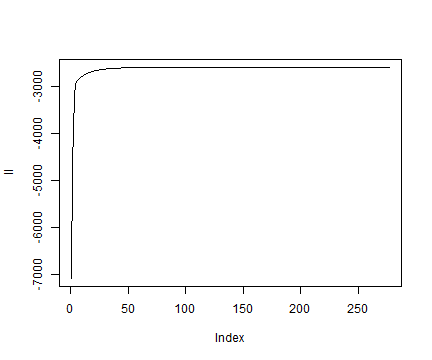

Finished Rprofile.site from C:/Program Files/R/R-3.5.1/etc


In [7]:
using RCall
ll = ll[1:iters]
@rput ll
reval("plot(ll, type='l')");

## Armijo Backtracking

In [8]:
function armijo(F,F₀,d,x₀,Y,X,counts; α₀ = 7.0, ρ = 0.5, z = 1e-4)
    x₊ = x₀ + α₀*d
    F₊ = F(x₊, Y, X, counts)
    i = 0
    while abs(F₊) > (1-z)*α₀*abs(F₀+ α₀*norm(d)) && i<5
        i +=1
        α₀ = ρ*α₀
        x₊ = x₀ + α₀*d
        F₊ = F(x₊, Y, X, counts)
    end
    return α₀
end

armijo (generic function with 1 method)

In [9]:
function logitback2(S,∇S, B; 
        Y=Y, X=X[:,1:7], counts=X[:,8], ϵ=1e-8, maxiter = 25)
  i = 0
  S₀ = S(B, Y, X, counts)
  ∇S₀ = ∇S(B, Y, X, counts)
  while norm(∇S₀) > ϵ && i <= maxiter
    i += 1
    #Search Direction
    ∇S₀ = ∇S(B, Y, X, counts)
    p = ∇S₀'
    #Step Length
    α = armijo(S,S₀,p,B,Y,X,counts)
    #Update Parameter
    B += α*p
    #Update Gradient
    S₀ = S(B, Y, X, counts)
  end

  return B, i
end

logitback2 (generic function with 1 method)

In [10]:
B = [1 1 1 1 1 1 1]
sol, iters = logitback2(admitll, admitgr, B; 
    Y=Y, X=X[:,1:7], counts=X[:,8], ϵ=1e-6, maxiter=3000);
sol'

7×1 Adjoint{Float64,Array{Float64,2}}:
  0.582008080610123  
  0.09984474343775683
 -0.0433444490162855 
 -1.2625306939891636 
 -1.2945426190086613 
 -1.7392288976302634 
 -3.3063588022334693 

In [11]:
iters

275

## Gauss-Newton
Add the Hessian.  A good step size seems to be 0.5 (1 goes singular).  Backtracking does not seem to be working for me.

In [12]:
function admithessian(B,Y,X,counts)
    Yf = convert(Array{Float64,1}, Y)
    H = zeros(24,24)
    for i in 1:24
        H[i,i] = (1/(1+exp(1).^(-dot(X[i,:],B))))*(1-(1/(1+exp(-dot(X[i,:],B))))).*counts[i]
    end
    return(X'*H*X./sum(counts))
end

admithessian (generic function with 1 method)

In [13]:
B = [1 1 1 1 1 1 1]'
admithessian(B,Y,X[:,1:7],X[:,8])

7×7 Array{Float64,2}:
 0.0988693   0.0197436   0.0132404   …  0.0134166   0.00835356  0.0120565 
 0.0197436   0.0197436   0.00024954     0.00374309  0.00392276  0.00340372
 0.0132404   0.00024954  0.0132404      0.0         0.0         0.0       
 0.0134584   0.00591908  0.0            0.0         0.0         0.0       
 0.0134166   0.00374309  0.0            0.0134166   0.0         0.0       
 0.00835356  0.00392276  0.0         …  0.0         0.00835356  0.0       
 0.0120565   0.00340372  0.0            0.0         0.0         0.0120565 

In [14]:
function logithess(S,∇S, B; 
        Y=Y, X=X[:,1:7], counts=X[:,8], alpha=1, ϵ=1e-8, maxiter = 25)
  i = 0
  S₀ = S(B, Y, X, counts)
  ∇S₀ = ∇S(B, Y, X, counts)
  while norm(∇S₀) > ϵ && i <= maxiter
    i += 1
    H = admithessian(B,Y,X,counts)
    #Search Direction
    ∇S₀ = ∇S(B, Y, X, counts)
    p = (inv(H)*∇S₀)
    #Step Length
    α = alpha # = backtrack(S,∇S₀,p',B,Y,X,counts)
    #Update Parameter
    B += α*p
    #Update Gradient
    S₀ = S(B, Y, X, counts)
  end

  return B, i
end

logithess (generic function with 1 method)

In [15]:
sol, iter = logithess(admitll, admitgr, B; 
    Y=Y, X=X[:,1:7], counts=X[:,8], alpha=.5, ϵ=1e-8, maxiter=100);
sol

7×1 Array{Float64,2}:
  0.582051393549194  
  0.09987010794011596
 -0.04339792880434964
 -1.262598023121301  
 -1.2946064678399474 
 -1.7393057294669727 
 -3.306479979906956  

In [16]:
iter

28

In [20]:
function logitbackhess(S,∇S, B; 
        Y=Y, X=X[:,1:7], counts=X[:,8], ϵ=1e-8, maxiter = 25)
  i = 0
  S₀ = S(B, Y, X, counts)
  ∇S₀ = ∇S(B, Y, X, counts)
  while norm(∇S₀) > ϵ && i <= maxiter
    i += 1
    H = admithessian(B,Y,X,counts)
    #Search Direction
    ∇S₀ = ∇S(B, Y, X, counts)
    p = (inv(H)*∇S₀)
    #Step Length
    α = backtrack(S,∇S₀,p',B,Y,X,counts,α₀ = 0.5)
    #α = armijo(S,S₀,p,B,Y,X,counts,α₀ = 0.5)
    #Update Parameter
    B += α*p
    #Update Gradient
    S₀ = S(B, Y, X, counts)
  end

  return B, i
end

logitbackhess (generic function with 1 method)

In [18]:
sol, iter = logitbackhess(admitll, admitgr, B; 
    Y=Y, X=X[:,1:7], counts=X[:,8], ϵ=1e-4, maxiter=1000);
sol

7×1 Array{Float64,2}:
  0.5822577982379723  
  0.09864978522313789 
 -0.043383183093950665
 -1.2626139027232577  
 -1.2946302664007703  
 -1.7392912181027556  
 -3.3059817627667933  

In [19]:
iter

454

In [18]:
function backtrackQuad(f::Function,f₀,g₀,x₀,Y,X,counts;
        α₀ = 1.0,C = 1e-4)
    x₊ = x₀ + α₀*(-g₀)
    f₊ = f(x₊, Y, X, counts)
    while f₊ > f₀ + C*α₀*g₀'*(-g₀)
        #α₀ = ρ*α₀
        c = f₀
        b = g₀'*(-g₀)
        a = (f(x₀ + α₀*(-g₀),Y,X,counts) - b*α₀ - c)/α₀^2

        α₀ = -b/(2*a)
        x₊ = x₀ + α₀*(-g₀)
        f₊ = f(x₊,Y,X,counts)
    end
    return α₀
end

backtrackQuad (generic function with 1 method)

In [19]:
function logithessquad(S,∇S, B; 
        Y=Y, X=X[:,1:7], counts=X[:,8], ϵ=1e-8, maxiter = 25)
  i = 0
  S₀ = S(B, Y, X, counts)
  ∇S₀ = ∇S(B, Y, X, counts)
  while norm(∇S₀) > ϵ && i <= maxiter
    i += 1
    H = admithessian(B,Y,X,counts)
    #Search Direction
    ∇S₀ = ∇S(B, Y, X, counts)
    p = (inv(H)*∇S₀)
    #Step Length
    α = backtrackQuad(S,∇S₀,p',B,Y,X,counts,α₀ = 0.5)
    #Update Parameter
    B += α*p
    #Update Gradient
    S₀ = S(B, Y, X, counts)
  end

  return B, i
end

logithessquad (generic function with 1 method)

In [20]:
sol, iter = logithessquad(admitll, admitgr, B; 
    Y=Y, X=X[:,1:7], counts=X[:,8], ϵ=1e-4, maxiter=1000);
sol

DimensionMismatch: DimensionMismatch("dimensions must match")